# Multi-source data fusion 

## Introduction

Phenology is an important supporting parameter of vegetation that can be derived from remote sensing data. It allows for instance to evaluate crop conditions in agriculture, or vegetation/crop type mapping and is an indicator for climate change. In this case, phenology is defined by:
* Start of season, a date and the corresponding value of the biophysical indicator
* End of season, a date and the corresponding value of the biophysical indicator

Deriving phenology accurately, requires a sufficiently dense vegetation index time series for a given pixel or area. At the same time, sufficiently high spatial resolution is needed, to avoid noise from sampling heterogeneous areas in a pixel or area. For time series analysis, high spatial accuracy is also an important requirement. Today, no single sensor can really satisfy all these requirements, limiting the accuracy of the predicted phenology parameters. In this use case, we will use openEO's capability to easily merge multiple datasets with different resolutions. Concretely we will use:
* ProbaV 10-daily composites: low spatial resolution (300m), but high temporal resolution
* Sentinel-2: high spatial resolution (10m), low temporal resolution
* Sentinel-1 Gamma0: high spatial \& temporal resolution, but no direct link to phenological parameters

This study will demonstrate the multi sensor data fusion approach is to merge the above data into a single dense vegetation index time series. This is provided as input to a phenology algorithm, implemented as a User-Defined Function (UDF), so that it can be easily replaced with other implementations. 

## Overview of the algorithm 

Below we give a step-by-step overview of the workflow, together with the most important openEO processes that were used to implement them.
1. Preprocessing Sentinel-2 data
  * Load scene classification (load_collection)
  * Load- bands 8 and 4 (load_collection)
  * Mask NDVI (mask)
  * Transform scene classification to binary mask (reduce_dimension)
  * Dilate cloud mask (apply_kernel)
  * Compute NDVI (ndvi)
2. Merging Sentinel-1 Gamma0: (load_collection/resample_cube_spatial/merge)
3. Preprocessing and merging PROBA-V 10-daily composites to Sentinel-2 resolution(load_collection/resample_cube_spatial/mask_polygon/merge)
4. Apply Deep learning model (GAN) to generate single NDVI (apply_neighborhood/run_udf)
5. Pixel wise smooth the resulting time series using Savitzky–Golay filter
6. Pixel wise derivation of phenological parameters (apply_dimension/run_udf)

## Demonstration

### Inputs

A small field will be used near the location of VITO Remote Sensing as shown in the figure. This area contains several fields cultivated for different type of crops (varying start and end of seasons), hence it is ideal candidate for showcasing the process chain. 

In [1]:
fieldgeom = {
    "type": "FeatureCollection",
    "name": "single_field",
    "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
    "features": [
        { "type": "Feature", "properties": { }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 5.017099, 51.223363 ], [ 5.023454, 51.223363 ], [ 5.023468, 51.219585 ], [ 5.017106, 51.219585 ], [ 5.017099, 51.223363 ] ] ] } }
    ]
}

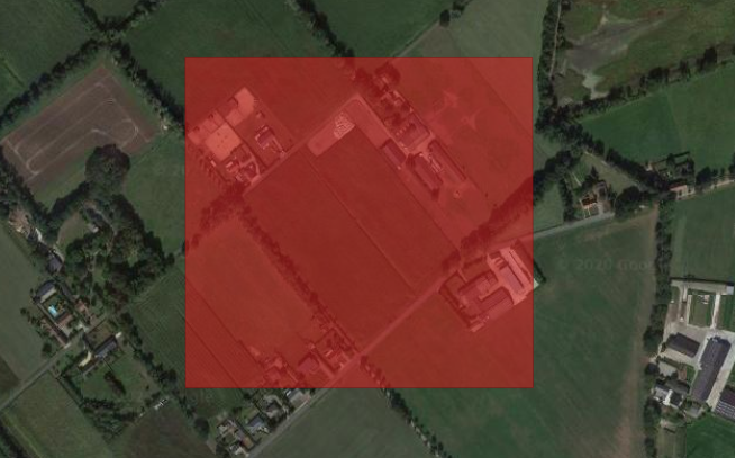

In [2]:
from IPython.display import Image,display
display(Image(filename='img/single_field.png'))

The season of 2019 will be analysed. Because both the fusion works with a large buffer around a given coordinate, the date range starts in the previous year and ends in the next.

In [3]:
year = 2019
startdate=str(year-1)+'-10-01'
enddate=str(year+1)+'-07-01'

And four more technical detail has to be specified: the credentials of the user, the location of the AI model on the cluster and the URL of the backend.

In [26]:
openeo_model= '/data/users/Public/banyait/usecase_multisource_data_fusion/gan_model.h5'
openeo_user= 'PLEASE_SET_USER'
openeo_pass= 'PLEASE_SET_PASSWORD'
openeo_url= 'https://openeo.vito.be'

### Building the process

OpenEO is designed such that the first the process is assembled client side and then can be submitted to the cluster to perform the computations.

#### Setup

Making sure openeo client is at latest version and connecting to the backend:

In [5]:
import sys
!{sys.executable} -m pip install --user --upgrade openeo
import openeo
eoconn = openeo.connect(openeo_url)
eoconn.authenticate_basic(openeo_user, openeo_pass)

Looking in indexes: https://artifactory.vgt.vito.be/api/pypi/python-packages/simple
Requirement already up-to-date: openeo in /data/users/Public/driesj/openeo/openeo-python-client (0.4.5a1)
You should consider upgrading via the 'pip install --upgrade pip' command.


<Connection to 'http://openeo-dev.vgt.vito.be/openeo/1.0.0/' with BearerAuth>

Then setting up the bouding box for the region of interest:

In [6]:
import shapely
polys = shapely.geometry.GeometryCollection(
    [shapely.geometry.shape(feature["geometry"]).buffer(0) for feature in fieldgeom["features"]])
extent = dict(zip(["west", "south", "east", "north"], polys.bounds))
extent['crs'] = "EPSG:4326"
bboxpoly=shapely.geometry.Polygon.from_bounds(*polys.bounds)

In [7]:
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

#### Preprocessing Sentinel-2 data (load_collection/band/mask/apply_kernel)
Load scene classification and band 4 and 8. Note that only the collection metadata is obtained at this point (no actual calculation is performed), so the process can be built.

In [8]:
s2_sceneclassification = eoconn.load_collection('TERRASCOPE_S2_TOC_V2', bands=['SCENECLASSIFICATION_20M']) \
    .band('SCENECLASSIFICATION_20M')
S2bands = eoconn.load_collection('TERRASCOPE_S2_TOC_V2', bands=['TOC-B04_10M', 'TOC-B08_10M'])

Transform scene classification to binary mask. This is done by using a fuzzy mask approach:
* selecting the pixels to be masked based on the classification types
* dilating the masked region by a few pixel using gaussian blur and select by threshold

In [11]:
import numpy 
import scipy.signal

def makekernel(size: int) -> numpy.ndarray:
    assert size % 2 == 1
    kernel_vect = scipy.signal.windows.gaussian(size, std=size / 6.0, sym=True)
    kernel = numpy.outer(kernel_vect, kernel_vect)
    kernel = kernel / kernel.sum()
    return kernel

def create_advanced_mask(band, band_math_workaround=True):
    # in openEO, 1 means mask (remove pixel) 0 means keep pixel
    classification = band

    # keep useful pixels, so set to 1 (remove) if smaller than threshold
    first_mask = ~ ((classification == 4) | (classification == 5) | (classification == 6) | (classification == 7))
    first_mask = first_mask.apply_kernel(makekernel(9))
    # remove pixels smaller than threshold, so pixels with a lot of neighbouring good pixels are retained?
    if band_math_workaround:
        first_mask = first_mask.add_dimension("bands", "mask", type="bands").band("mask")
    first_mask = first_mask > 0.057

    # remove cloud pixels so set to 1 (remove) if larger than threshold
    second_mask = (classification == 3) | (classification == 8) | (classification == 9) | (classification == 10)
    second_mask = second_mask.apply_kernel(makekernel(81))
    if band_math_workaround:
        second_mask = second_mask.add_dimension("bands", "mask", type="bands").band("mask")
    second_mask = second_mask > 0.1

    # TODO: the use of filter_temporal is a trick to make cube merging work, needs to be fixed in openeo client
    return first_mask.filter_temporal(startdate, enddate) | second_mask.filter_temporal(startdate, enddate)
    # return first_mask | second_mask
    # return first_mask

S2mask = create_advanced_mask(s2_sceneclassification)
S2bands = S2bands.mask(S2mask)

Compute NDVI

In [12]:
B4band = S2bands.band('TOC-B04_10M')
B8band = S2bands.band('TOC-B08_10M')
S2ndvi = (B8band-B4band)/(B8band+B4band)
S2ndvi = S2ndvi.add_dimension("bands", "S2ndvi", type="bands")

#### Merging Sentinel-1 Gamma0 (load_collection/resample_cube_spatial/merge)

Creating a merged cube by aligning the Sentinel-1 collection with the Sentinel-2 and calling merge.

In [13]:
S1bands = eoconn.load_collection('TERRASCOPE_S1_GAMMA0_V1', bands=['VH', 'VV'])
S1bands = S1bands.resample_cube_spatial(S2ndvi)
merged_cube = S2ndvi
merged_cube = merged_cube.merge(S1bands)

#### Preprocessing and merging PROBA-V 10-daily composites to Sentinel-2 resolution(load_collection/resample_cube_spatial/merge/mask_polygon)

The Sentinel-2 data has 10m resolution, while the PROBA-V images are at 300m. Therefore a resampling has to be performed before the two data sources can be merged into a single dataset. 

The masking to the bounding box (mask_polygon(bboxpoly)) helps to optimize the process and restrict resampling to the area of interest.

In [14]:
PVndvi = eoconn.load_collection('PROBAV_L3_S10_TOC_NDVI_333M', bands=['ndvi'])
PVndvi = PVndvi.resample_cube_spatial(S2ndvi)
PVndvi = PVndvi.mask_polygon(bboxpoly)
merged_cube = merged_cube.merge(PVndvi)

Finally, by specifying the date range, the merged cube will be ready for the data fusion step.

In [15]:
merged_cube = merged_cube.filter_temporal(startdate, enddate).filter_bbox(**extent)

#### Apply Deep learning model (GAN) to generate single NDVI (apply_neighborhood/run_udf)

The idea is that gaps in the Sentinel-2 NDVI are filled with information from the other sources. This is achieved by using a previously trained a GAN model. This is a technique that is able to reconstruct realistic looking photographs, but has also proven its use in scientific applications. 

The current model is designed such that it takes a spatio-temporal datacubes of 128x128 pixel area for all inputs with an overlap of 16 pixels. Hence, it can combine information provided by a time series of a pixel, as well as the local spatial neighbourhood of a pixel. This is done by employing the apply_neighborhood process.

The model itself is not included in the use case code, we simply load a pre-designed architecture with the weights. This demonstrates the ability of openEO to integrate with modern machine learning libraries like Tensorflow.

Runtime parametrization of a UDF is under development at the moment, therefore simple string substitution approach was used (the UDFString class).

In [16]:
from pathlib import Path
import re
from udf.udf_gan import load_cropsar_px_udf

gan_udf_code = load_cropsar_px_udf()

ndvi_cube = merged_cube.apply_neighborhood(
    lambda data: data.run_udf(
        udf=gan_udf_code,
        runtime='Python',
        context={
            'prediction_model': openeo_model,
            'startdate': startdate,
            'enddate': enddate
        }),
        size=[
            {'dimension': 'x', 'value': 224, 'unit': 'px'},
            {'dimension': 'y', 'value': 224, 'unit': 'px'}
        ],
        overlap=[
            {'dimension': 'x', 'value': 16, 'unit': 'px'},
            {'dimension': 'y', 'value': 16, 'unit': 'px'}
        ]
)

#### Pixel wise smoothing the resulting time series using Savitzky–Golay filter (apply_dimension/run_udf)
Smoothing in the temporal dimension, independently on every pixel. For that aim the standard Savitzky–Golay filter was utilized from the SciPy package. The illustration shows the time series of several points in the field.

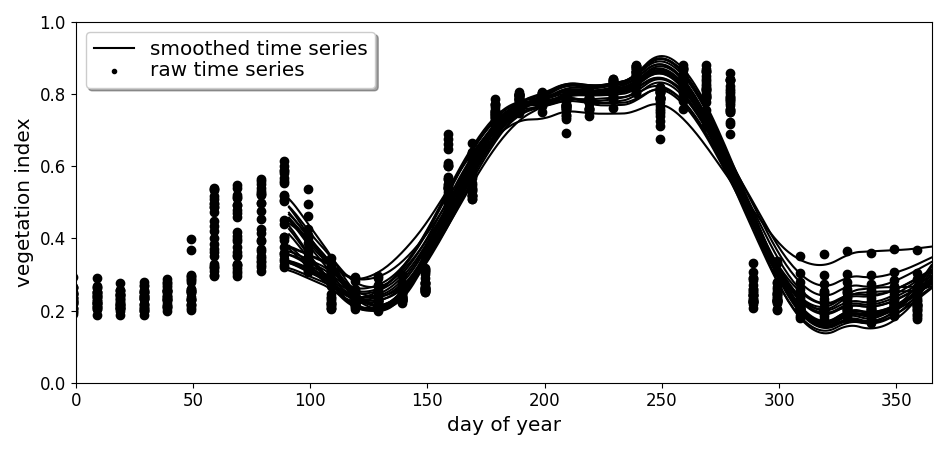

In [17]:
display(Image(filename='img/gan.png'))

#### Pixel wise derivation of phenological parameters (apply_dimension/run_udf)
Derives phenological parameters at pixel level from the dense NDVI time series. Over the season the NDVI value grows as the plants grew and at the end of the season it drops at harvest time. For this demonstration, we choose a very simple implementation which in essence just searches for the local minimums. More advanced implementations are available, for instance by using the Timesat library. 

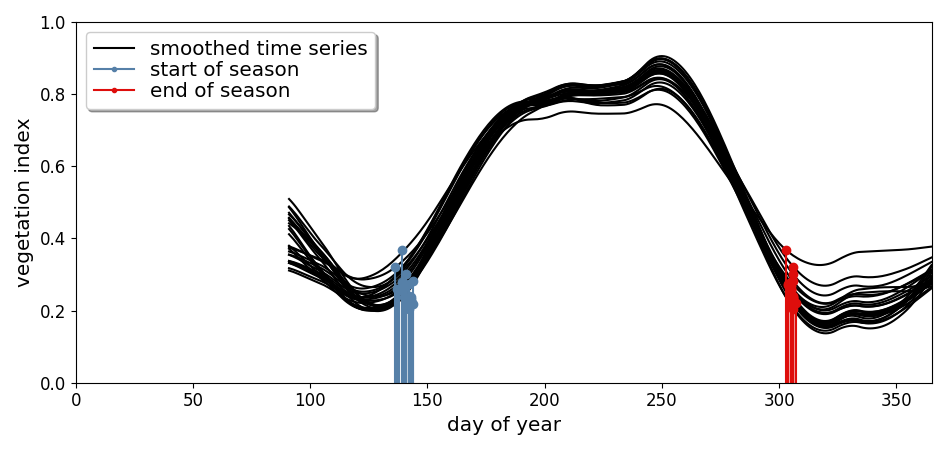

In [18]:
display(Image(filename='img/pheno.png'))

#### Combined execution of smoothing and phenology
Due to performance reasons it was deemed beneficial to merge the two UDF-s into a single step. This approach saves the overhead for passing 1+ year daily time series data between spark tasks.

In [20]:
phenology_cube = ndvi_cube.apply_dimension(UDFString('udf/udf_savitzkygolaysmooth_phenology.py').value, dimension='t',runtime="Python")

With this the process building is concluded. It can be inspected by calling the visualizer or printing the graph.

In [25]:
import json
with open('phenology_graph.json','w') as f:
    json.dump(phenology_cube.graph,f,indent=2)

### Executing the process
A process can either be excuted via interactive or batch mode. 
* interactive mode allows quick execution of smaller jobs while keeping the connection
* batch mode allows to run long lasting, large jobs while detaching and reconnecting for the results later

Let's choose GeoTIFF for the format of the results.

In [20]:
#job_options = {
#    'driver-memory': '4G',
#    'executor-memory': '4G'
#}
#phenology_cube.execute_batch("eos_sos.tif",out_format='GTiff', job_options=job_options, parameters={"tiled":True})
phenology_cube.download("eos_sos.tif", format='GTiff')

### Results
After a successful run the resulting image will contain two bands: start and end of season values as day of years.

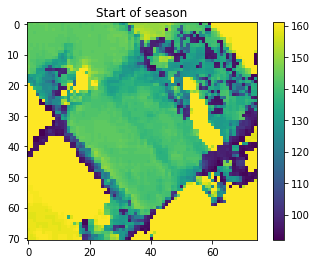

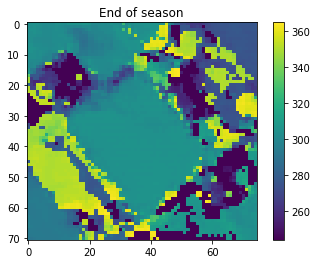

In [19]:
import rasterio
from matplotlib import pyplot as plt

with rasterio.open('eos_sos.tif', 'r') as ds:
    img = ds.read()  

plt.title("Start of season")
plt.imshow(img[0])    
plt.colorbar()
plt.show()

plt.title("End of season")
plt.imshow(img[1])    
plt.colorbar()
plt.show()